In [2]:
D.<x> = PolynomialRing(QQ)
R = PolynomialRing(QQ,'x')
S = PowerSeriesRing(QQ,'x', default_prec=300)
L=LaurentSeriesRing(QQ,'x', default_prec=300)
#S.<x,y>=PowerSeriesRing(QQ,default_prec=300)
# Using "R = PolynomialRing(QQ,'x')" produces an error.
# Yet using S as defined here is fine (see definition of Fraleigh4 below)
# But S = PowerSeriesRing(QQ,'x','y') also produces an error.
Scplx= PowerSeriesRing(CC,'x',default_prec=300)
def pochhammer(x,n):
    return product ([x+k for k in [0..n-1]])
def cRaleigh2(alpha,beta,nu):
    pchhmrA = pochhammer(alpha,nu)
    pchhmrB = pochhammer(beta,nu)
    fnu=factorial(nu)
    answer = D(pchhmrA*pchhmrB/fnu^2)
    return answer
def term(alpha,beta,p):
    return D(1/(alpha + p) + 1/(beta + p) - 2/(1 + p))
def eRaleigh(alpha, beta, nu):
    return D(sum([term(alpha, beta, p) for p in [0..nu - 1]]))
def FstarRaleigh2(alpha,beta,u,terms):
    fsr = sum([cRaleigh2(alpha, beta, nu)*eRaleigh(alpha,beta,nu)*u^nu for nu in [1..terms]])
    return D(fsr)
def Fraleigh2(alpha,beta,u,terms): 
    return D(sum([cRaleigh2(alpha,beta,nu)*u^nu for nu in [0..terms]]))
def FstarRaleigh3(n,m,x):
    alpha = (1/2-1/m)/2
    beta = (1/2+1/m)/2
    fsr2 = FstarRaleigh2(alpha,beta,x,n)
    return D(fsr2)
def Fraleigh4(n,m,x):
    alpha = (1/2-1/m)/2
    beta = (1/2+1/m)/2
    fr2 = Fraleigh2(alpha,beta,x,n)
    return D(fr2)
def exNo3c(n,m):
    a1 = S(x)*exp(S(FstarRaleigh3(n,m,x)/Fraleigh4(n,m,x))).O(2*n)
    # S(x) instead of x in df of a1 to avoid an error message
    # after use of the stripQuotationMarks command below.
    a2 = S(a1).O(n+1)
    return a2 # applying S to argument of exp is key.
def J(n,m):
    exn = exNo3c(n+2,m)
    jnm = 1/exn.reverse()
    return jnm.O(n+1) # Jtest is faster than J, and they agree.
def normalJ(n,m):
    f = J(n,m)
    return f.truncate(n+1)
def Jcoefficient(n,m):
    f = J(n+2,m)
    f1 = f.truncate(n+1)
    f1=f1.list()
    f1=Set(f1)
    g1 = f.truncate(n)
    g1 = g1.list()
    g1 = set(g1)
    h = f1.difference(g1)
    h = h.list()
    return h[0]
def xjNewStep(n,m): 
    f=J(n,m)
    fl=f.list()
    return (sum(c*x**i*(m**3*2**6)**i for i,c in enumerate(fl)))
def xjNew(n,m):
    return xjNewStep(n-1,m)
def xjNewCoefficient(n,m):
    if n>0:return (xjNew(n,m)-xjNew(n-1,m))/x^n
    if n==0:return 1
def xjNewTest(n,m):
    return D(xjNewStep(n-1,m))
def j(n,m):return xjNew(n,m)/x

def H4(n,m): # this is the definition in the published interpolations paper (2021):
    # def. 8.4
    jay=J(n+1,m)
    djay=x*derivative(jay,x) # bc variable is tau, not x; chain rule.
    numerator = djay^2
    denominator = jay*(jay-1)
    return ((S(numerator/denominator)^(1/(m-2))).O(n+1)).polynomial()
    #if argument is an S type then 'polynomial' takes no argument.

def H4strike(n,m): #this applies the strike operator to the version of H4 that *is*
    #in the Integers paper.
    poly=H4(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [0..polydegree])
    return answer


def H6(n,m):
    def base6(n,m):
        jay=J(n+1,m)
        num=(x*derivative(jay,x))^m # chain rule; variable is tau not x.
        den = expand(jay^(m-1)*(jay-1))
        return L((-1)^m*(num/den)).O(n+1)
    return S(base6(n,m)^(1/(m-2))).polynomial()
     #if argument is an S type then 'polynomial' takes no argument.

def H6strike(n,m): #this applies the strike operator to the version of H4 that *is*
    #in the Integers paper.
    poly=H6(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [0..polydegree])
    return answer

def polynomialCoefficient(n,poly):
    return poly.list()[n]
def factorpairToFactor(factorpair):
    (monomial,exponent)=factorpair
    return monomial^exponent
def numericalfactor(polynomial):
    fp=polynomial.factor()
    lst=[factorpairToFactor(factorpair) for factorpair in fp]
    return polynomial/product(lst)
def lastfactor(polynomial):
    fp=polynomial.factor()
    fp=FiniteEnumeratedSet(fp)
    return factorpairToFactor(fp.last())
def reduced(polynomial):
    return numericalfactor(polynomial)*lastfactor(polynomial)
def stripQuotationMarks(string):
    var('x')
    return sage_eval(string,locals={'x':x})
def nieburTau(n):
# The contortions below sidestep mysterious (to me) error messages...
# nieburTau is an algorith for Ramanujan''s tau from the paper
# "A formula for Ramanujan's tau-function" by Douglas Niebur.
# (He spells tau with the Greek letter.)
    def step1(n,k):
        return 35*k^4-52*k^3*n+18*k^2*n^2
    def step2(n,k):
        return sigma(k)*sigma(n-k)
    def step3(n):
        ans=0
        for k in [1..n-1]:
            ans=ans+step1(n,k)*step2(n,k)
        return 24*ans
    return n^4*sigma(n)-step3(n)

def deltaDagger(n,m):
    def ddstep1(n,m):
        return D(S(expand((H4(n+2,m)^3)))).truncate(n+1)
    def ddstep2(n,m):
        return D(S((H6(n+2,m)^2))).truncate(n+1)
    return ((ddstep1(n,m)-ddstep2(n,m))/1728)

def deltaDaggerStrike(n,m): #this applies the strike operator to the version of H4 that *is*
    #in the Integers paper.
    poly=deltaDagger(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree])
    return answer

def deltaDagger2(n,m):
    def ddstep1(n,m):
        return D(S(expand((H4(n+2,m)^3)))).truncate(n+1)
    def ddstep2(n,m):
        return D(S((H6(n+2,m)^2))).truncate(n+1)
    return (ddstep1(n,m)-ddstep2(n,m))

# def deltaDaggerStrike(n,m):
 #   return S(((H4strike(n,3)^3-H6strike(n,3)^2)/1728)).truncate(n+1)
    
def deltaDagger2Strike(n,m): #this applies the strike operator to the version of H4 that *is*
    #in the Integers paper.
    poly=deltaDagger2(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree])
    return answer

def first(list):return list[0]
def last(list):return list[-1]

def rmnjntau(n):
    answer=0
    for k in [1..n-1]:
        answer=answer+(6*k-4*(n-k))*sigma(k,3)*sigma(n-k,5)
    answer=(5*sigma(n,3)+7*sigma(n,5))*n/12-35*answer
    return answer

def element(k,listo):
    if k>len(listo):return (print("bad k"))
    return listo[k-1]

def mobiusInverseOfFunction(g,n):
    dv=divisors(n)
    nd=len(dv)
    f=0
    for k in [1..nd]:
        dvk=element(k,dv)
        f=f+moebius(dvk)*g(n/dvk)
    return f

def mobiusInverseOfList(g,n):
    dv=divisors(n)
    nd=len(dv)
    f=0
    for k in [1..nd]:
        dvk=element(k,dv)
        gndvk=element(n/dvk,g)
        f=f+moebius(dvk)*gndvk
    return f

def drop_first_element(listo):
    lenth=len(listo)
    answer=[]
    for k in [1..lenth-1]:
        answer=answer+[listo[k]]
    return answer

def factorSeriesFromLists(lsst,bound):
    truncatedlist=drop_first_element(lsst)
    F=[element(1,truncatedlist)]
    nswr=[-mobiusInverseOfList(F,1)/1]
    for n in [2..bound]:
        summ=0
        for k in [1..n-1]:
            ekf=element(k,F)
            tnk=element(n-k,truncatedlist)
            summ=summ+ekf*tnk
        Fn=n*element(n,truncatedlist)-summ
        F=F+[Fn]
        xpn=-mobiusInverseOfList(F,n)/n
        nswr=nswr+[xpn]
    return nswr

def factorSeriesFromListsWithTracking(lsst,bound):
    truncatedlist=drop_first_element(lsst)
    F=[element(1,truncatedlist)]
    nswr=[-mobiusInverseOfList(F,1)/1]
    for n in [2..bound]:
        summ=0
        for k in [1..n-1]:
            ekf=element(k,F)
            tnk=element(n-k,truncatedlist)
            summ=summ+ekf*tnk
            print((n,k))
        Fn=n*element(n,truncatedlist)-summ
        F=F+[Fn]
        xpn=-mobiusInverseOfList(F,n)/n
        nswr=nswr+[xpn]
        print("answer length: ",len(nswr))
    return nswr



print("o1k")

o1k


In [ ]:
#from 'superlong H4 24sept22', Output snipped.

data=[]
import time
start=time.time()/60
for m in [3..1203]:
    poly=H4(200,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/24sept22no1.txt','wb') # H4 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [1204..2403]:
    poly=H4(200,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/25sept22no2.txt','wb') # H4 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [2404..3610]:
    poly=H4(200,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/26sept22no13.txt','wb') # H4 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [3611..4818]:
    poly=H4(200,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/27sept22no1.txt','wb') # H4 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

In [ ]:
#from 'superlong H6 test1oct22', Output snipped.

data=[]
import time
start=time.time()/60
for m in [3..1203]:
    poly=H6(200,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/24sept22no2.txt','wb') # H6 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [1204..2403]:
    poly=H6(200,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/25sept22no1.txt','wb') # H6 series (date typo)
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [2404..3610]:
    poly=H6(200,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/28sept22no1.txt','wb') # H6 series (date typo)
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [3611..4818]:
    poly=H6(200,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/29sept22no1.txt','wb') # H6 series (date typo)
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

In [3]:
import pickle
r41 = open('/Users/barrybrent/24sept22no1.txt','rb')  # superlong H4 series 
rs41=pickle.load(r41)
r41.close()
s41=stripQuotationMarks(rs41)

r61 = open('/Users/barrybrent/24sept22no2.txt','rb') # superlong H6 series
rs61=pickle.load(r61)
r61.close()
s61=stripQuotationMarks(rs61)


import time
w1 = open('/Users/barrybrent/2oct22no1.txt','wb') # 1st superlong deltaDagger2Strike series
data=[]
start = time.time()
for n in [0..1200]:
    m=s41[n][0]
    h6squared=s61[n][1]^2
    h4cubed=s41[n][1]^3
    dagger=D((h4cubed-h6squared)).truncate(200)
    poly=dagger
    polylist=poly.list()
    polydegree=poly.degree()
    answer=D(sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree]))
    data=data+[[m,answer]]
    finish = time.time()
    print([m,answer.degree(),finish-start])
t = pickle.dumps(str(data))
w1.write(t)
w1.close()
print(len(t))

[3, 199, 0.6354107856750488]
[4, 199, 0.6988768577575684]
[5, 199, 0.7855868339538574]
[6, 199, 0.830676794052124]
[7, 199, 0.9205009937286377]
[8, 199, 1.0034778118133545]
[9, 199, 1.097902774810791]
[10, 199, 1.1795258522033691]
[11, 199, 1.2782258987426758]
[12, 199, 1.366478681564331]
[13, 199, 1.460434913635254]
[14, 199, 1.5445997714996338]
[15, 199, 1.6454048156738281]
[16, 199, 1.7306828498840332]
[17, 199, 1.831589698791504]
[18, 199, 1.9154198169708252]
[19, 199, 2.0198588371276855]
[20, 199, 2.1165707111358643]
[21, 199, 2.226451873779297]
[22, 199, 2.313657760620117]
[23, 199, 2.416400909423828]
[24, 199, 2.507964849472046]
[25, 199, 2.6098837852478027]
[26, 199, 2.7050817012786865]
[27, 199, 2.807008981704712]
[28, 199, 2.9021737575531006]
[29, 199, 3.0056047439575195]
[30, 199, 3.0952908992767334]
[31, 199, 3.1969847679138184]
[32, 199, 3.2921957969665527]
[33, 199, 3.400465726852417]
[34, 199, 3.4944026470184326]
[35, 199, 3.603773832321167]
[36, 199, 3.7010769844055176]

[276, 199, 32.375929832458496]
[277, 199, 32.50706887245178]
[278, 199, 32.61616373062134]
[279, 199, 32.75472283363342]
[280, 199, 32.879591941833496]
[281, 199, 33.009586811065674]
[282, 199, 33.12430167198181]
[283, 199, 33.261515855789185]
[284, 199, 33.38879370689392]
[285, 199, 33.52654266357422]
[286, 199, 33.641960859298706]
[287, 199, 33.775951862335205]
[288, 199, 33.8930869102478]
[289, 199, 34.03539681434631]
[290, 199, 34.144192934036255]
[291, 199, 34.28427076339722]
[292, 199, 34.40164399147034]
[293, 199, 34.54062366485596]
[294, 199, 34.65620398521423]
[295, 199, 34.794148683547974]
[296, 199, 34.91040897369385]
[297, 199, 35.05251479148865]
[298, 199, 35.16035079956055]
[299, 199, 35.29251670837402]
[300, 199, 35.42517876625061]
[301, 199, 35.5580689907074]
[302, 199, 35.67429876327515]
[303, 199, 35.80722689628601]
[304, 199, 35.9252610206604]
[305, 199, 36.070327043533325]
[306, 199, 36.19740080833435]
[307, 199, 36.329957723617554]
[308, 199, 36.46341395378113]
[30

[548, 199, 67.91359686851501]
[549, 199, 68.06145882606506]
[550, 199, 68.18434977531433]
[551, 199, 68.32362174987793]
[552, 199, 68.45980477333069]
[553, 199, 68.59513974189758]
[554, 199, 68.72306776046753]
[555, 199, 68.86803889274597]
[556, 199, 68.99234366416931]
[557, 199, 69.13860583305359]
[558, 199, 69.25784182548523]
[559, 199, 69.39459466934204]
[560, 199, 69.52371096611023]
[561, 199, 69.67099380493164]
[562, 199, 69.7937867641449]
[563, 199, 69.9348349571228]
[564, 199, 70.0655608177185]
[565, 199, 70.20858788490295]
[566, 199, 70.32662081718445]
[567, 199, 70.46971797943115]
[568, 199, 70.60115098953247]
[569, 199, 70.73171782493591]
[570, 199, 70.85427284240723]
[571, 199, 70.98965382575989]
[572, 199, 71.13097381591797]
[573, 199, 71.27328276634216]
[574, 199, 71.40178084373474]
[575, 199, 71.54867196083069]
[576, 199, 71.6746039390564]
[577, 199, 71.8180480003357]
[578, 199, 71.94140076637268]
[579, 199, 72.09122085571289]
[580, 199, 72.22461175918579]
[581, 199, 72.3

[822, 199, 105.2080807685852]
[823, 199, 105.34499669075012]
[824, 199, 105.4742488861084]
[825, 199, 105.62778282165527]
[826, 199, 105.75212788581848]
[827, 199, 105.89516377449036]
[828, 199, 106.02879476547241]
[829, 199, 106.1671769618988]
[830, 199, 106.29818272590637]
[831, 199, 106.43989682197571]
[832, 199, 106.56569290161133]
[833, 199, 106.71535468101501]
[834, 199, 106.83901882171631]
[835, 199, 106.98620271682739]
[836, 199, 107.12813687324524]
[837, 199, 107.27329778671265]
[838, 199, 107.39182686805725]
[839, 199, 107.52844786643982]
[840, 199, 107.66699290275574]
[841, 199, 107.80590176582336]
[842, 199, 107.92814373970032]
[843, 199, 108.07546496391296]
[844, 199, 108.19973397254944]
[845, 199, 108.345627784729]
[846, 199, 108.46498584747314]
[847, 199, 108.61518168449402]
[848, 199, 108.74045491218567]
[849, 199, 108.88459897041321]
[850, 199, 109.01412773132324]
[851, 199, 109.15176296234131]
[852, 199, 109.28807497024536]
[853, 199, 109.42987275123596]
[854, 199, 10

[1086, 199, 141.55623483657837]
[1087, 199, 141.69287967681885]
[1088, 199, 141.82834887504578]
[1089, 199, 141.9796748161316]
[1090, 199, 142.11486101150513]
[1091, 199, 142.25564885139465]
[1092, 199, 142.40247774124146]
[1093, 199, 142.54152178764343]
[1094, 199, 142.66137862205505]
[1095, 199, 142.80846166610718]
[1096, 199, 142.944885969162]
[1097, 199, 143.08779883384705]
[1098, 199, 143.2186689376831]
[1099, 199, 143.36149191856384]
[1100, 199, 143.49535989761353]
[1101, 199, 143.6384618282318]
[1102, 199, 143.75723576545715]
[1103, 199, 143.90004992485046]
[1104, 199, 144.03455090522766]
[1105, 199, 144.1866898536682]
[1106, 199, 144.31626963615417]
[1107, 199, 144.4679889678955]
[1108, 199, 144.60177183151245]
[1109, 199, 144.74430584907532]
[1110, 199, 144.88153982162476]
[1111, 199, 145.032075881958]
[1112, 199, 145.17321181297302]
[1113, 199, 145.32470870018005]
[1114, 199, 145.45089673995972]
[1115, 199, 145.5973858833313]
[1116, 199, 145.73091578483582]
[1117, 199, 145.87

In [4]:
import pickle
r = open('/Users/barrybrent/2oct22no1.txt','rb') # 1st superlong deltaDagger2Strike series
rs=pickle.load(r)
r.close()
s=stripQuotationMarks(rs)
print(s[0])
data=[]
poly=s[0][1]
for k in [1..199]:
    diff=polynomialCoefficient(k,poly)-1728*rmnjntau(k)
    data=data+[diff]
print(data)

[3, 1258660343001600*x^199 + 2519627690391552*x^198 - 4969886119523712*x^197 + 4316427851968512*x^196 - 1215128881290240*x^195 - 3110962714739712*x^194 + 9404445920443776*x^193 + 1175424973406208*x^192 + 4773432989822976*x^191 - 2135586481459200*x^190 + 2120229934018560*x^189 - 6835582632001536*x^188 - 6379767684186624*x^187 + 552260989550592*x^186 - 1520796049839360*x^185 + 2721571692871680*x^184 + 3029240372239872*x^183 - 401185408425984*x^182 - 1722426329119104*x^181 + 1396179859415040*x^180 + 2905431940419840*x^179 + 1036506258385920*x^178 - 2259669903805440*x^177 + 911925650128896*x^176 + 737785192435200*x^175 - 1341970499358720*x^174 - 1642269512870784*x^173 + 43561224880128*x^172 - 2093637461287680*x^171 + 1383325982115840*x^170 - 2520079253095104*x^169 - 615966934302720*x^168 + 4760352965749248*x^167 + 1216585253431296*x^166 + 1124424014837760*x^165 - 783740086198272*x^164 - 618335008568064*x^163 - 69058691707392*x^162 - 539417571323904*x^161 - 1641758022696960*x^160 - 69501203

In [6]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
r1 = open('/Users/barrybrent/2oct22no1.txt','rb') # 1st superlong deltaDagger2Strike series
r1s=pickle.load(r1) 
r1.close()
s1=stripQuotationMarks(r1s)
data1=[]
bound=199
def m(n):return s1[n][0]
def pre_g(n):return s1[n][1]
def g(n):return list(D(pre_g(n)))
for index in [0..1200]:
    dfeg=drop_first_element(g(index))
    fs=factorSeriesFromLists(dfeg,bound-1)
    em=m(index)
    data1=data1+[[em,fs]]
    print([em,len(fs)])

# interpolating polynomials
w1 =  open('/Users/barrybrent/2oct22no2.txt','wb') #1st superlong deltaDagger2 exponents
t1 = pickle.dumps(str(data1))
w1.write(t1)
w1.close()

[3, 198]
[4, 198]
[5, 198]
[6, 198]
[7, 198]
[8, 198]
[9, 198]
[10, 198]
[11, 198]
[12, 198]
[13, 198]
[14, 198]
[15, 198]
[16, 198]
[17, 198]
[18, 198]
[19, 198]
[20, 198]
[21, 198]
[22, 198]
[23, 198]
[24, 198]
[25, 198]
[26, 198]
[27, 198]
[28, 198]
[29, 198]
[30, 198]
[31, 198]
[32, 198]
[33, 198]
[34, 198]
[35, 198]
[36, 198]
[37, 198]
[38, 198]
[39, 198]
[40, 198]
[41, 198]
[42, 198]
[43, 198]
[44, 198]
[45, 198]
[46, 198]
[47, 198]
[48, 198]
[49, 198]
[50, 198]
[51, 198]
[52, 198]
[53, 198]
[54, 198]
[55, 198]
[56, 198]
[57, 198]
[58, 198]
[59, 198]
[60, 198]
[61, 198]
[62, 198]
[63, 198]
[64, 198]
[65, 198]
[66, 198]
[67, 198]
[68, 198]
[69, 198]
[70, 198]
[71, 198]
[72, 198]
[73, 198]
[74, 198]
[75, 198]
[76, 198]
[77, 198]
[78, 198]
[79, 198]
[80, 198]
[81, 198]
[82, 198]
[83, 198]
[84, 198]
[85, 198]
[86, 198]
[87, 198]
[88, 198]
[89, 198]
[90, 198]
[91, 198]
[92, 198]
[93, 198]
[94, 198]
[95, 198]
[96, 198]
[97, 198]
[98, 198]
[99, 198]
[100, 198]
[101, 198]
[102, 198]
[103

[758, 198]
[759, 198]
[760, 198]
[761, 198]
[762, 198]
[763, 198]
[764, 198]
[765, 198]
[766, 198]
[767, 198]
[768, 198]
[769, 198]
[770, 198]
[771, 198]
[772, 198]
[773, 198]
[774, 198]
[775, 198]
[776, 198]
[777, 198]
[778, 198]
[779, 198]
[780, 198]
[781, 198]
[782, 198]
[783, 198]
[784, 198]
[785, 198]
[786, 198]
[787, 198]
[788, 198]
[789, 198]
[790, 198]
[791, 198]
[792, 198]
[793, 198]
[794, 198]
[795, 198]
[796, 198]
[797, 198]
[798, 198]
[799, 198]
[800, 198]
[801, 198]
[802, 198]
[803, 198]
[804, 198]
[805, 198]
[806, 198]
[807, 198]
[808, 198]
[809, 198]
[810, 198]
[811, 198]
[812, 198]
[813, 198]
[814, 198]
[815, 198]
[816, 198]
[817, 198]
[818, 198]
[819, 198]
[820, 198]
[821, 198]
[822, 198]
[823, 198]
[824, 198]
[825, 198]
[826, 198]
[827, 198]
[828, 198]
[829, 198]
[830, 198]
[831, 198]
[832, 198]
[833, 198]
[834, 198]
[835, 198]
[836, 198]
[837, 198]
[838, 198]
[839, 198]
[840, 198]
[841, 198]
[842, 198]
[843, 198]
[844, 198]
[845, 198]
[846, 198]
[847, 198]
[848, 198]

In [6]:
import pickle
rv =open('/Users/barrybrent/13sept22no2.txt','rb') # 1st verylong deltaDagger2Strike series
rvs=pickle.load(rv)
vs=stripQuotationMarks(rvs)

import pickle
rs = open('/Users/barrybrent/2oct22no1.txt','rb') # 1st superlong deltaDagger2Strike series
rss=pickle.load(rs)
ss=stripQuotationMarks(rss)

no=[]
for k in [0..3]:
    vpoly=D(vs[k][1])
    spoly=D(ss[k][1])
    tv=vpoly.truncate(5)
    ts=spoly.truncate(5)
    print(tv-ts)
    print(tv)
    print(ts)
    print("==========================================================================")

0
-2543616*x^4 + 435456*x^3 - 41472*x^2 + 1728*x
-2543616*x^4 + 435456*x^3 - 41472*x^2 + 1728*x
0
-29844045824*x^4 - 171835392*x^3 - 972800*x^2 + 3712*x
-29844045824*x^4 - 171835392*x^3 - 972800*x^2 + 3712*x
0
-1694852140000/3*x^4 - 4286288000/3*x^3 - 5092000*x^2 + 6880*x
-1694852140000/3*x^4 - 4286288000/3*x^3 - 5092000*x^2 + 6880*x
0
-5339181219840*x^4 - 6606028800*x^3 - 17694720*x^2 + 11520*x
-5339181219840*x^4 - 6606028800*x^3 - 17694720*x^2 + 11520*x


In [2]:
import pickle
r42= open('/Users/barrybrent/25sept22no2.txt','rb') # 2nd superlong H4 series
rs42=pickle.load(r42)
r42.close()
s42=stripQuotationMarks(rs42)

r62 =  open('/Users/barrybrent/25sept22no1.txt','rb')# 2nd superlong H6 series
rs62=pickle.load(r62)
r62.close()
s62=stripQuotationMarks(rs62)

print((len(s42),len(s62)))

(1200, 1200)


In [13]:
import pickle
r42 = open('/Users/barrybrent/25sept22no2.txt','rb') # 2nd superlong H4 series 
rs42=pickle.load(r42)
r42.close()
s42=stripQuotationMarks(rs42)

r62 =  open('/Users/barrybrent/25sept22no1.txt','rb') # 2nd superlong H6 series 
rs62=pickle.load(r62)
r62.close()
s62=stripQuotationMarks(rs62)


import time
w1 = open('/Users/barrybrent/2oct22no3.txt','wb') # 2nd superlong deltaDagger2Strike series
data=[]
start = time.time()
for n in [0..1199]:
    start = time.time()
    m=s42[n][0]
    h6squared=s62[n][1]^2
    h4cubed=s42[n][1]^3
    dagger=D((h4cubed-h6squared)).truncate(200)
    poly=dagger
    polylist=poly.list()
    polydegree=poly.degree()
    answer=D(sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree]))
    data=data+[[m,answer]]
    finish = time.time()
    print([m,answer.degree(),finish-start])
t = pickle.dumps(str(data))
w1.write(t)
w1.close()
print(len(t))

[1204, 199, 0.15422630310058594]
[1205, 199, 0.16277289390563965]
[1206, 199, 0.13469409942626953]
[1207, 199, 0.1591188907623291]
[1208, 199, 0.13733196258544922]
[1209, 199, 0.16164302825927734]
[1210, 199, 0.1339740753173828]
[1211, 199, 0.15171217918395996]
[1212, 199, 0.14267182350158691]
[1213, 199, 0.1448040008544922]
[1214, 199, 0.12810301780700684]
[1215, 199, 0.15386104583740234]
[1216, 199, 0.14119291305541992]
[1217, 199, 0.1438441276550293]
[1218, 199, 0.13567113876342773]
[1219, 199, 0.14525103569030762]
[1220, 199, 0.14273810386657715]
[1221, 199, 0.14986109733581543]
[1222, 199, 0.12851405143737793]
[1223, 199, 0.15523982048034668]
[1224, 199, 0.1389937400817871]
[1225, 199, 0.15155696868896484]
[1226, 199, 0.13764619827270508]
[1227, 199, 0.14585018157958984]
[1228, 199, 0.13332700729370117]
[1229, 199, 0.1460590362548828]
[1230, 199, 0.13690710067749023]
[1231, 199, 0.14213299751281738]
[1232, 199, 0.14844083786010742]
[1233, 199, 0.14737510681152344]
[1234, 199, 0.13

[1456, 199, 0.13214588165283203]
[1457, 199, 0.14691472053527832]
[1458, 199, 0.13228726387023926]
[1459, 199, 0.14525413513183594]
[1460, 199, 0.1371479034423828]
[1461, 199, 0.14475011825561523]
[1462, 199, 0.12275576591491699]
[1463, 199, 0.15194296836853027]
[1464, 199, 0.1375598907470703]
[1465, 199, 0.14658880233764648]
[1466, 199, 0.12978124618530273]
[1467, 199, 0.1435089111328125]
[1468, 199, 0.13583588600158691]
[1469, 199, 0.143934965133667]
[1470, 199, 0.13576483726501465]
[1471, 199, 0.14586901664733887]
[1472, 199, 0.12982702255249023]
[1473, 199, 0.14667892456054688]
[1474, 199, 0.12802696228027344]
[1475, 199, 0.14651703834533691]
[1476, 199, 0.13565731048583984]
[1477, 199, 0.1455821990966797]
[1478, 199, 0.12671303749084473]
[1479, 199, 0.14482593536376953]
[1480, 199, 0.13898873329162598]
[1481, 199, 0.14969897270202637]
[1482, 199, 0.13660287857055664]
[1483, 199, 0.1436011791229248]
[1484, 199, 0.13930511474609375]
[1485, 199, 0.15456700325012207]
[1486, 199, 0.129

[1708, 199, 0.14545297622680664]
[1709, 199, 0.14734482765197754]
[1710, 199, 0.14162087440490723]
[1711, 199, 0.14864087104797363]
[1712, 199, 0.13944506645202637]
[1713, 199, 0.15184521675109863]
[1714, 199, 0.13521909713745117]
[1715, 199, 0.15155386924743652]
[1716, 199, 0.1404428482055664]
[1717, 199, 0.1450328826904297]
[1718, 199, 0.12685227394104004]
[1719, 199, 0.15040087699890137]
[1720, 199, 0.1397080421447754]
[1721, 199, 0.1423351764678955]
[1722, 199, 0.13603901863098145]
[1723, 199, 0.14217114448547363]
[1724, 199, 0.1388859748840332]
[1725, 199, 0.14920806884765625]
[1726, 199, 0.12596607208251953]
[1727, 199, 0.14658403396606445]
[1728, 199, 0.13250994682312012]
[1729, 199, 0.15204501152038574]
[1730, 199, 0.12771916389465332]
[1731, 199, 0.14760327339172363]
[1732, 199, 0.1362297534942627]
[1733, 199, 0.14596915245056152]
[1734, 199, 0.13267898559570312]
[1735, 199, 0.14589190483093262]
[1736, 199, 0.13776016235351562]
[1737, 199, 0.14819097518920898]
[1738, 199, 0.13

[1960, 199, 0.13943004608154297]
[1961, 199, 0.14731216430664062]
[1962, 199, 0.1335299015045166]
[1963, 199, 0.1501598358154297]
[1964, 199, 0.13865089416503906]
[1965, 199, 0.15387511253356934]
[1966, 199, 0.12704992294311523]
[1967, 199, 0.1483018398284912]
[1968, 199, 0.1362156867980957]
[1969, 199, 0.14568209648132324]
[1970, 199, 0.13402271270751953]
[1971, 199, 0.14587116241455078]
[1972, 199, 0.14033985137939453]
[1973, 199, 0.14670777320861816]
[1974, 199, 0.13458037376403809]
[1975, 199, 0.14732599258422852]
[1976, 199, 0.14252209663391113]
[1977, 199, 0.14843225479125977]
[1978, 199, 0.1316239833831787]
[1979, 199, 0.14439797401428223]
[1980, 199, 0.14609909057617188]
[1981, 199, 0.14542794227600098]
[1982, 199, 0.1278090476989746]
[1983, 199, 0.14668798446655273]
[1984, 199, 0.13076305389404297]
[1985, 199, 0.1472461223602295]
[1986, 199, 0.13468003273010254]
[1987, 199, 0.14669275283813477]
[1988, 199, 0.1405949592590332]
[1989, 199, 0.15029096603393555]
[1990, 199, 0.1328

[2212, 199, 0.15060830116271973]
[2213, 199, 0.1491260528564453]
[2214, 199, 0.14110517501831055]
[2215, 199, 0.15816020965576172]
[2216, 199, 0.14613103866577148]
[2217, 199, 0.14990806579589844]
[2218, 199, 0.13573527336120605]
[2219, 199, 0.15012693405151367]
[2220, 199, 0.14646291732788086]
[2221, 199, 0.14506292343139648]
[2222, 199, 0.14006781578063965]
[2223, 199, 0.15476727485656738]
[2224, 199, 0.14730000495910645]
[2225, 199, 0.15567302703857422]
[2226, 199, 0.14713788032531738]
[2227, 199, 0.1523120403289795]
[2228, 199, 0.14488506317138672]
[2229, 199, 0.15208983421325684]
[2230, 199, 0.1462879180908203]
[2231, 199, 0.16092801094055176]
[2232, 199, 0.14356493949890137]
[2233, 199, 0.15712690353393555]
[2234, 199, 0.14069581031799316]
[2235, 199, 0.1548171043395996]
[2236, 199, 0.13845276832580566]
[2237, 199, 0.15159296989440918]
[2238, 199, 0.14172101020812988]
[2239, 199, 0.14886093139648438]
[2240, 199, 0.14150309562683105]
[2241, 199, 0.1522231101989746]
[2242, 199, 0.1

In [14]:
import pickle
rv = open('/Users/barrybrent/14sept22no1.txt','rb') # 2nd verylong deltaDagger2Strike series
rvs=pickle.load(rv)
vs=stripQuotationMarks(rvs)

import pickle
rs = open('/Users/barrybrent/2oct22no3.txt','rb') # 2nd superlong deltaDagger2Strike series
rss=pickle.load(rs)
ss=stripQuotationMarks(rss)

no=[]
for k in [0..3]:
    vpoly=D(vs[k][1])
    spoly=D(ss[k][1])
    tv=vpoly.truncate(5)
    ts=spoly.truncate(5)
    print(tv-ts)
    print(tv)
    print(ts)
    print("==========================================================================")


0
-48052283861060045686592101520029108404224*x^4 + 7050968440044183924072643166208*x^3 - 1896987528607271475200*x^2 + 83799517312*x
-48052283861060045686592101520029108404224*x^4 + 7050968440044183924072643166208*x^3 - 1896987528607271475200*x^2 + 83799517312*x
0
-145601453601975156241449259153473286540000/3*x^4 + 21311788074729722116688827952000/3*x^3 - 1906463809500536452000*x^2 + 84008474080*x
-145601453601975156241449259153473286540000/3*x^4 + 21311788074729722116688827952000/3*x^3 - 1906463809500536452000*x^2 + 84008474080*x
0
-49019771538304935183367160690329560023040*x^4 + 7157243579288090054340221337600*x^3 - 1915979506058718904320*x^2 + 84217777920*x
-49019771538304935183367160690329560023040*x^4 + 7157243579288090054340221337600*x^3 - 1915979506058718904320*x^2 + 84217777920*x
0
-148530545161767239906937502690454783268160/3*x^4 + 7210913163735287510526970888192*x^3 - 1925534749329338128832*x^2 + 84427429120*x
-148530545161767239906937502690454783268160/3*x^4 + 721091316373528

In [9]:
import pickle
r2 = open('/Users/barrybrent/2oct22no3.txt','rb') # 2nd superlong deltaDagger2Strike series
r2s=pickle.load(r2) 
r2.close()
s2=stripQuotationMarks(r2s)
print(len(s2))

1200


In [10]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
r2 = open('/Users/barrybrent/2oct22no3.txt','rb') # 2nd superlong deltaDagger2Strike series
r2s=pickle.load(r2) 
r2.close()
s2=stripQuotationMarks(r2s)
data2=[]
bound=199
def m(n):return s2[n][0]
def pre_g(n):return s2[n][1]
def g(n):return list(D(pre_g(n)))
for index in [0..1199]:
    dfeg=drop_first_element(g(index))
    fs=factorSeriesFromLists(dfeg,bound-1)
    em=m(index)
    data2=data2+[[em,fs]]
    print([em,len(fs)])

w2 = open('/Users/barrybrent/3oct22no3.txt','wb') #2nd superlong deltaDagger2 exponents
t2 = pickle.dumps(str(data2))
w2.write(t2)
w2.close()

[1204, 198]
[1205, 198]
[1206, 198]
[1207, 198]
[1208, 198]
[1209, 198]
[1210, 198]
[1211, 198]
[1212, 198]
[1213, 198]
[1214, 198]
[1215, 198]
[1216, 198]
[1217, 198]
[1218, 198]
[1219, 198]
[1220, 198]
[1221, 198]
[1222, 198]
[1223, 198]
[1224, 198]
[1225, 198]
[1226, 198]
[1227, 198]
[1228, 198]
[1229, 198]
[1230, 198]
[1231, 198]
[1232, 198]
[1233, 198]
[1234, 198]
[1235, 198]
[1236, 198]
[1237, 198]
[1238, 198]
[1239, 198]
[1240, 198]
[1241, 198]
[1242, 198]
[1243, 198]
[1244, 198]
[1245, 198]
[1246, 198]
[1247, 198]
[1248, 198]
[1249, 198]
[1250, 198]
[1251, 198]
[1252, 198]
[1253, 198]
[1254, 198]
[1255, 198]
[1256, 198]
[1257, 198]
[1258, 198]
[1259, 198]
[1260, 198]
[1261, 198]
[1262, 198]
[1263, 198]
[1264, 198]
[1265, 198]
[1266, 198]
[1267, 198]
[1268, 198]
[1269, 198]
[1270, 198]
[1271, 198]
[1272, 198]
[1273, 198]
[1274, 198]
[1275, 198]
[1276, 198]
[1277, 198]
[1278, 198]
[1279, 198]
[1280, 198]
[1281, 198]
[1282, 198]
[1283, 198]
[1284, 198]
[1285, 198]
[1286, 198]
[128

[1887, 198]
[1888, 198]
[1889, 198]
[1890, 198]
[1891, 198]
[1892, 198]
[1893, 198]
[1894, 198]
[1895, 198]
[1896, 198]
[1897, 198]
[1898, 198]
[1899, 198]
[1900, 198]
[1901, 198]
[1902, 198]
[1903, 198]
[1904, 198]
[1905, 198]
[1906, 198]
[1907, 198]
[1908, 198]
[1909, 198]
[1910, 198]
[1911, 198]
[1912, 198]
[1913, 198]
[1914, 198]
[1915, 198]
[1916, 198]
[1917, 198]
[1918, 198]
[1919, 198]
[1920, 198]
[1921, 198]
[1922, 198]
[1923, 198]
[1924, 198]
[1925, 198]
[1926, 198]
[1927, 198]
[1928, 198]
[1929, 198]
[1930, 198]
[1931, 198]
[1932, 198]
[1933, 198]
[1934, 198]
[1935, 198]
[1936, 198]
[1937, 198]
[1938, 198]
[1939, 198]
[1940, 198]
[1941, 198]
[1942, 198]
[1943, 198]
[1944, 198]
[1945, 198]
[1946, 198]
[1947, 198]
[1948, 198]
[1949, 198]
[1950, 198]
[1951, 198]
[1952, 198]
[1953, 198]
[1954, 198]
[1955, 198]
[1956, 198]
[1957, 198]
[1958, 198]
[1959, 198]
[1960, 198]
[1961, 198]
[1962, 198]
[1963, 198]
[1964, 198]
[1965, 198]
[1966, 198]
[1967, 198]
[1968, 198]
[1969, 198]
[197

In [4]:
import pickle
r43 = open('/Users/barrybrent/26sept22no13.txt','rb') #3rd superlong H4 series
rs43=pickle.load(r43)
r43.close()
s43=stripQuotationMarks(rs43)

r63 =open('/Users/barrybrent/28sept22no1.txt','rb') # 3rd superlong H6 series
rs63=pickle.load(r63)
r63.close()
s63=stripQuotationMarks(rs63)

print((len(s43),len(s63)))

(1207, 1207)


In [5]:
import pickle
r43 = open('/Users/barrybrent/26sept22no13.txt','rb') #3rd superlong H4 series
rs43=pickle.load(r43)
r43.close()
s43=stripQuotationMarks(rs43)

r63 =open('/Users/barrybrent/28sept22no1.txt','rb') # 3rd superlong H6 series
rs63=pickle.load(r63)
r63.close()
s63=stripQuotationMarks(rs63)

import time
w1 = open('/Users/barrybrent/2oct22no5.txt','wb') # 3rd superlongdeltaDagger2Strike series
data=[]
start = time.time()
for n in [0..1206]:
    start = time.time()
    m=s43[n][0]
    h6squared=s63[n][1]^2
    h4cubed=s43[n][1]^3
    dagger=D((h4cubed-h6squared)).truncate(200)
    poly=dagger
    polylist=poly.list()
    polydegree=poly.degree()
    answer=D(sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree]))
    data=data+[[m,answer]]
    finish = time.time()
    print([m,answer.degree(),finish-start])
t = pickle.dumps(str(data))
w1.write(t)
w1.close()

[2404, 199, 0.9829308986663818]
[2405, 199, 0.15163969993591309]
[2406, 199, 0.1344146728515625]
[2407, 199, 0.15795111656188965]
[2408, 199, 0.14541912078857422]
[2409, 199, 0.16307616233825684]
[2410, 199, 0.14167404174804688]
[2411, 199, 0.1546008586883545]
[2412, 199, 0.145859956741333]
[2413, 199, 0.15476202964782715]
[2414, 199, 0.1375119686126709]
[2415, 199, 0.16153407096862793]
[2416, 199, 0.1513679027557373]
[2417, 199, 0.15035080909729004]
[2418, 199, 0.1413419246673584]
[2419, 199, 0.15295720100402832]
[2420, 199, 0.15038800239562988]
[2421, 199, 0.15456581115722656]
[2422, 199, 0.13985919952392578]
[2423, 199, 0.15628600120544434]
[2424, 199, 0.141998291015625]
[2425, 199, 0.1538097858428955]
[2426, 199, 0.13791584968566895]
[2427, 199, 0.15503478050231934]
[2428, 199, 0.13765811920166016]
[2429, 199, 0.15251684188842773]
[2430, 199, 0.1395421028137207]
[2431, 199, 0.15356683731079102]
[2432, 199, 0.1355438232421875]
[2433, 199, 0.15599989891052246]
[2434, 199, 0.131315231

[2656, 199, 0.1437702178955078]
[2657, 199, 0.15275812149047852]
[2658, 199, 0.14063000679016113]
[2659, 199, 0.1501469612121582]
[2660, 199, 0.14804601669311523]
[2661, 199, 0.15423202514648438]
[2662, 199, 0.13793706893920898]
[2663, 199, 0.15019011497497559]
[2664, 199, 0.14285898208618164]
[2665, 199, 0.16203522682189941]
[2666, 199, 0.13880300521850586]
[2667, 199, 0.15747404098510742]
[2668, 199, 0.14360404014587402]
[2669, 199, 0.15168404579162598]
[2670, 199, 0.14419102668762207]
[2671, 199, 0.15081000328063965]
[2672, 199, 0.15294909477233887]
[2673, 199, 0.15288114547729492]
[2674, 199, 0.14172792434692383]
[2675, 199, 0.14995527267456055]
[2676, 199, 0.14879584312438965]
[2677, 199, 0.1509699821472168]
[2678, 199, 0.1400151252746582]
[2679, 199, 0.15417003631591797]
[2680, 199, 0.14794278144836426]
[2681, 199, 0.14841604232788086]
[2682, 199, 0.1425619125366211]
[2683, 199, 0.1508927345275879]
[2684, 199, 0.14572525024414062]
[2685, 199, 0.15631628036499023]
[2686, 199, 0.13

[2908, 199, 0.14667081832885742]
[2909, 199, 0.15337777137756348]
[2910, 199, 0.14099478721618652]
[2911, 199, 0.15124201774597168]
[2912, 199, 0.14656805992126465]
[2913, 199, 0.15906500816345215]
[2914, 199, 0.14295482635498047]
[2915, 199, 0.15683603286743164]
[2916, 199, 0.1522080898284912]
[2917, 199, 0.1572878360748291]
[2918, 199, 0.13917970657348633]
[2919, 199, 0.1540999412536621]
[2920, 199, 0.14591097831726074]
[2921, 199, 0.1525256633758545]
[2922, 199, 0.14135456085205078]
[2923, 199, 0.15264296531677246]
[2924, 199, 0.1522660255432129]
[2925, 199, 0.16030597686767578]
[2926, 199, 0.14618420600891113]
[2927, 199, 0.15267729759216309]
[2928, 199, 0.1450200080871582]
[2929, 199, 0.14974689483642578]
[2930, 199, 0.1519179344177246]
[2931, 199, 0.1572408676147461]
[2932, 199, 0.14590787887573242]
[2933, 199, 0.15672683715820312]
[2934, 199, 0.14193201065063477]
[2935, 199, 0.1617569923400879]
[2936, 199, 0.15227222442626953]
[2937, 199, 0.1558218002319336]
[2938, 199, 0.140284

[3160, 199, 0.14728307723999023]
[3161, 199, 0.14741182327270508]
[3162, 199, 0.14086604118347168]
[3163, 199, 0.14839696884155273]
[3164, 199, 0.14615416526794434]
[3165, 199, 0.15630316734313965]
[3166, 199, 0.13982725143432617]
[3167, 199, 0.15277099609375]
[3168, 199, 0.14242076873779297]
[3169, 199, 0.14711713790893555]
[3170, 199, 0.13504481315612793]
[3171, 199, 0.1517319679260254]
[3172, 199, 0.14272308349609375]
[3173, 199, 0.1543900966644287]
[3174, 199, 0.14308714866638184]
[3175, 199, 0.15963196754455566]
[3176, 199, 0.14276671409606934]
[3177, 199, 0.1585688591003418]
[3178, 199, 0.1403810977935791]
[3179, 199, 0.14951491355895996]
[3180, 199, 0.14821410179138184]
[3181, 199, 0.15146589279174805]
[3182, 199, 0.14631414413452148]
[3183, 199, 0.15682768821716309]
[3184, 199, 0.14315295219421387]
[3185, 199, 0.16690301895141602]
[3186, 199, 0.14455080032348633]
[3187, 199, 0.14999794960021973]
[3188, 199, 0.1444709300994873]
[3189, 199, 0.1538069248199463]
[3190, 199, 0.13961

[3412, 199, 0.15909194946289062]
[3413, 199, 0.1547870635986328]
[3414, 199, 0.1453568935394287]
[3415, 199, 0.15560221672058105]
[3416, 199, 0.14432215690612793]
[3417, 199, 0.16527318954467773]
[3418, 199, 0.15372323989868164]
[3419, 199, 0.16011786460876465]
[3420, 199, 0.15880894660949707]
[3421, 199, 0.15984010696411133]
[3422, 199, 0.14241600036621094]
[3423, 199, 0.15703606605529785]
[3424, 199, 0.15520167350769043]
[3425, 199, 0.15552711486816406]
[3426, 199, 0.15295004844665527]
[3427, 199, 0.1530168056488037]
[3428, 199, 0.1538538932800293]
[3429, 199, 0.16235995292663574]
[3430, 199, 0.15054988861083984]
[3431, 199, 0.16069626808166504]
[3432, 199, 0.15703487396240234]
[3433, 199, 0.15276622772216797]
[3434, 199, 0.14210891723632812]
[3435, 199, 0.16880297660827637]
[3436, 199, 0.15022826194763184]
[3437, 199, 0.15701007843017578]
[3438, 199, 0.14256811141967773]
[3439, 199, 0.15461087226867676]
[3440, 199, 0.14427995681762695]
[3441, 199, 0.1562190055847168]
[3442, 199, 0.1

In [8]:
import pickle
rv =open('/Users/barrybrent/14sept22no2.txt','rb') # 3rd verylong deltaDagger2Strike series
rvs=pickle.load(rv)
vs=stripQuotationMarks(rvs)

import pickle
rs =  open('/Users/barrybrent/2oct22no5.txt','rb') # 3rd superlong deltaDagger2Strike series
rss=pickle.load(rs)
ss=stripQuotationMarks(rss)

no=[]
for k in [0..3]:
    vpoly=D(vs[k][1])
    spoly=D(ss[k][1])
    tv=vpoly.truncate(5)
    ts=spoly.truncate(5)
    print(tv-ts)
    print(tv)
    print(ts)
    print("==========================================================================")

0
-581782258926755763691625318000872527793487872/3*x^4 + 3580271938683022617546194850807808*x^3 - 120323710687381090457600*x^2 + 666967990912*x
-581782258926755763691625318000872527793487872/3*x^4 + 3580271938683022617546194850807808*x^3 - 120323710687381090457600*x^2 + 666967990912*x
0
-194898079023571686850423694676563540482980000*x^4 + 3593707918312263406457252472464000*x^3 - 120624382767231698212000*x^2 + 667800621280*x
-194898079023571686850423694676563540482980000*x^4 + 3593707918312263406457252472464000*x^3 - 120624382767231698212000*x^2 + 667800621280*x
0
-195873190095284365067720224794278382262026240*x^4 + 3607188699076222680719631581184000*x^3 - 120925680700956301393920*x^2 + 668633944320*x
-195873190095284365067720224794278382262026240*x^4 + 3607188699076222680719631581184000*x^3 - 120925680700956301393920*x^2 + 668633944320*x
0
-196852771410189743065896207711752786536099520*x^4 + 3620714411632807544077782489633792*x^3 - 121227605530301410096832*x^2 + 669467960320*x
-1968527

In [6]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
r3 = open('/Users/barrybrent/2oct22no5.txt','rb') # 3rd superlongdeltaDagger2Strike series
r3s=pickle.load(r3) 
r3.close()
s3=stripQuotationMarks(r3s)
print(len(s3))

1207


In [7]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
r3 = open('/Users/barrybrent/2oct22no5.txt','rb') # 3rd superlongdeltaDagger2Strike series
r3s=pickle.load(r3) 
r3.close()
s3=stripQuotationMarks(r3s)
data3=[]
bound=199
def m(n):return s3[n][0]
def pre_g(n):return s3[n][1]
def g(n):return list(D(pre_g(n)))
for index in [0..1206]:
    dfeg=drop_first_element(g(index))
    fs=factorSeriesFromLists(dfeg,bound-1)
    em=m(index)
    data3=data3+[[em,fs]]
    print([em,len(fs)])

w3 = open('/Users/barrybrent/2oct22no6.txt','wb') #3rd superlong deltaDagger2 exponents
t3 = pickle.dumps(str(data3))
w3.write(t3)
w3.close()

[2404, 198]
[2405, 198]
[2406, 198]
[2407, 198]
[2408, 198]
[2409, 198]
[2410, 198]
[2411, 198]
[2412, 198]
[2413, 198]
[2414, 198]
[2415, 198]
[2416, 198]
[2417, 198]
[2418, 198]
[2419, 198]
[2420, 198]
[2421, 198]
[2422, 198]
[2423, 198]
[2424, 198]
[2425, 198]
[2426, 198]
[2427, 198]
[2428, 198]
[2429, 198]
[2430, 198]
[2431, 198]
[2432, 198]
[2433, 198]
[2434, 198]
[2435, 198]
[2436, 198]
[2437, 198]
[2438, 198]
[2439, 198]
[2440, 198]
[2441, 198]
[2442, 198]
[2443, 198]
[2444, 198]
[2445, 198]
[2446, 198]
[2447, 198]
[2448, 198]
[2449, 198]
[2450, 198]
[2451, 198]
[2452, 198]
[2453, 198]
[2454, 198]
[2455, 198]
[2456, 198]
[2457, 198]
[2458, 198]
[2459, 198]
[2460, 198]
[2461, 198]
[2462, 198]
[2463, 198]
[2464, 198]
[2465, 198]
[2466, 198]
[2467, 198]
[2468, 198]
[2469, 198]
[2470, 198]
[2471, 198]
[2472, 198]
[2473, 198]
[2474, 198]
[2475, 198]
[2476, 198]
[2477, 198]
[2478, 198]
[2479, 198]
[2480, 198]
[2481, 198]
[2482, 198]
[2483, 198]
[2484, 198]
[2485, 198]
[2486, 198]
[248

[3087, 198]
[3088, 198]
[3089, 198]
[3090, 198]
[3091, 198]
[3092, 198]
[3093, 198]
[3094, 198]
[3095, 198]
[3096, 198]
[3097, 198]
[3098, 198]
[3099, 198]
[3100, 198]
[3101, 198]
[3102, 198]
[3103, 198]
[3104, 198]
[3105, 198]
[3106, 198]
[3107, 198]
[3108, 198]
[3109, 198]
[3110, 198]
[3111, 198]
[3112, 198]
[3113, 198]
[3114, 198]
[3115, 198]
[3116, 198]
[3117, 198]
[3118, 198]
[3119, 198]
[3120, 198]
[3121, 198]
[3122, 198]
[3123, 198]
[3124, 198]
[3125, 198]
[3126, 198]
[3127, 198]
[3128, 198]
[3129, 198]
[3130, 198]
[3131, 198]
[3132, 198]
[3133, 198]
[3134, 198]
[3135, 198]
[3136, 198]
[3137, 198]
[3138, 198]
[3139, 198]
[3140, 198]
[3141, 198]
[3142, 198]
[3143, 198]
[3144, 198]
[3145, 198]
[3146, 198]
[3147, 198]
[3148, 198]
[3149, 198]
[3150, 198]
[3151, 198]
[3152, 198]
[3153, 198]
[3154, 198]
[3155, 198]
[3156, 198]
[3157, 198]
[3158, 198]
[3159, 198]
[3160, 198]
[3161, 198]
[3162, 198]
[3163, 198]
[3164, 198]
[3165, 198]
[3166, 198]
[3167, 198]
[3168, 198]
[3169, 198]
[317

In [3]:
import pickle
r44 =open('/Users/barrybrent/12sept22no10.txt','rb') # 4th superlong H4 series 
rs44=pickle.load(r44)
r44.close()
s44=stripQuotationMarks(rs44)

r64 = open('/Users/barrybrent/12sept22no12.txt','rb') # 4th superlong H6 series 
rs64=pickle.load(r64)
r64.close()
s64=stripQuotationMarks(rs64)

print((len(s44),len(s64)))

(1208, 1208)


In [4]:
import pickle
r44 =open('/Users/barrybrent/27sept22no1.txt','rb') # 4th superlong H4 series 
rs44=pickle.load(r44)
r44.close()
s44=stripQuotationMarks(rs44)

r64 = open('/Users/barrybrent/29sept22no1.txt','rb') # 4th superlong H6 series 
rs64=pickle.load(r64)
r64.close()
s64=stripQuotationMarks(rs64)


w1 = open('/Users/barrybrent/3oct22no1.txt','wb') # 4th superlong deltaDagger2 series
data=[]
import time
start = time.time()
for n in [0..1206]:
    m=s44[n][0]
    h6squared=s64[n][1]^2
    h4cubed=s44[n][1]^3
    dagger=D((h4cubed-h6squared)).truncate(200)
    poly=dagger
    polylist=poly.list()
    polydegree=poly.degree()
    answer=D(sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree]))
    data=data+[[m,answer]]
    finish = time.time()
    print([m,answer.degree(),finish-start])
t = pickle.dumps(str(data))
w1.write(t)
w1.close()

[3611, 199, 1.044219970703125]
[3612, 199, 1.2024998664855957]
[3613, 199, 1.3565559387207031]
[3614, 199, 1.5065867900848389]
[3615, 199, 1.665177822113037]
[3616, 199, 1.814967155456543]
[3617, 199, 1.9723708629608154]
[3618, 199, 2.1201980113983154]
[3619, 199, 2.2739310264587402]
[3620, 199, 2.4266231060028076]
[3621, 199, 2.584796905517578]
[3622, 199, 2.728224039077759]
[3623, 199, 2.8835577964782715]
[3624, 199, 3.0324931144714355]
[3625, 199, 3.187694787979126]
[3626, 199, 3.333979845046997]
[3627, 199, 3.4945950508117676]
[3628, 199, 3.641508102416992]
[3629, 199, 3.8017940521240234]
[3630, 199, 3.943490982055664]
[3631, 199, 4.095057964324951]
[3632, 199, 4.238105058670044]
[3633, 199, 4.396330118179321]
[3634, 199, 4.538920879364014]
[3635, 199, 4.694009065628052]
[3636, 199, 4.84660792350769]
[3637, 199, 4.997813940048218]
[3638, 199, 5.140313148498535]
[3639, 199, 5.294436931610107]
[3640, 199, 5.454753160476685]
[3641, 199, 5.605813026428223]
[3642, 199, 5.755596160888672

[3873, 199, 40.54025602340698]
[3874, 199, 40.67943096160889]
[3875, 199, 40.832107067108154]
[3876, 199, 40.98127889633179]
[3877, 199, 41.13624811172485]
[3878, 199, 41.27515506744385]
[3879, 199, 41.42634296417236]
[3880, 199, 41.57284903526306]
[3881, 199, 41.71966004371643]
[3882, 199, 41.86112689971924]
[3883, 199, 42.018068075180054]
[3884, 199, 42.16353988647461]
[3885, 199, 42.324445962905884]
[3886, 199, 42.46273684501648]
[3887, 199, 42.61763095855713]
[3888, 199, 42.7692129611969]
[3889, 199, 42.92375206947327]
[3890, 199, 43.06370997428894]
[3891, 199, 43.21649217605591]
[3892, 199, 43.364161014556885]
[3893, 199, 43.5181450843811]
[3894, 199, 43.65772485733032]
[3895, 199, 43.82240700721741]
[3896, 199, 43.96877598762512]
[3897, 199, 44.12388610839844]
[3898, 199, 44.261117935180664]
[3899, 199, 44.421027183532715]
[3900, 199, 44.576225996017456]
[3901, 199, 44.73651576042175]
[3902, 199, 44.87786293029785]
[3903, 199, 45.02918291091919]
[3904, 199, 45.16554498672485]
[39

[4137, 199, 80.4225869178772]
[4138, 199, 80.56438899040222]
[4139, 199, 80.71894097328186]
[4140, 199, 80.87448978424072]
[4141, 199, 81.0287938117981]
[4142, 199, 81.1801929473877]
[4143, 199, 81.33974003791809]
[4144, 199, 81.48825287818909]
[4145, 199, 81.64024806022644]
[4146, 199, 81.78450679779053]
[4147, 199, 81.9473819732666]
[4148, 199, 82.09574604034424]
[4149, 199, 82.25466704368591]
[4150, 199, 82.39958310127258]
[4151, 199, 82.55164694786072]
[4152, 199, 82.69978499412537]
[4153, 199, 82.85113191604614]
[4154, 199, 82.99513602256775]
[4155, 199, 83.15210509300232]
[4156, 199, 83.29957890510559]
[4157, 199, 83.45338296890259]
[4158, 199, 83.59656000137329]
[4159, 199, 83.75020003318787]
[4160, 199, 83.89316892623901]
[4161, 199, 84.05029892921448]
[4162, 199, 84.18540287017822]
[4163, 199, 84.34060001373291]
[4164, 199, 84.49052810668945]
[4165, 199, 84.65499806404114]
[4166, 199, 84.79770088195801]
[4167, 199, 84.95403909683228]
[4168, 199, 85.10653495788574]
[4169, 199, 

[4399, 199, 120.34212517738342]
[4400, 199, 120.49507999420166]
[4401, 199, 120.66273999214172]
[4402, 199, 120.80587005615234]
[4403, 199, 120.96462106704712]
[4404, 199, 121.11705994606018]
[4405, 199, 121.28365707397461]
[4406, 199, 121.43152689933777]
[4407, 199, 121.59929919242859]
[4408, 199, 121.74897408485413]
[4409, 199, 121.91395902633667]
[4410, 199, 122.06763005256653]
[4411, 199, 122.23267698287964]
[4412, 199, 122.38637113571167]
[4413, 199, 122.55081915855408]
[4414, 199, 122.69533014297485]
[4415, 199, 122.85641694068909]
[4416, 199, 123.00462913513184]
[4417, 199, 123.1648461818695]
[4418, 199, 123.31001091003418]
[4419, 199, 123.46721696853638]
[4420, 199, 123.62171792984009]
[4421, 199, 123.78428196907043]
[4422, 199, 123.93304991722107]
[4423, 199, 124.0854139328003]
[4424, 199, 124.24251079559326]
[4425, 199, 124.40633606910706]
[4426, 199, 124.55118703842163]
[4427, 199, 124.70830583572388]
[4428, 199, 124.86213517189026]
[4429, 199, 125.01799988746643]
[4430, 199

[4659, 199, 160.627347946167]
[4660, 199, 160.78012490272522]
[4661, 199, 160.9371988773346]
[4662, 199, 161.08623909950256]
[4663, 199, 161.246994972229]
[4664, 199, 161.39705181121826]
[4665, 199, 161.55944919586182]
[4666, 199, 161.70403003692627]
[4667, 199, 161.8654978275299]
[4668, 199, 162.02097487449646]
[4669, 199, 162.17898607254028]
[4670, 199, 162.3225531578064]
[4671, 199, 162.48368310928345]
[4672, 199, 162.6303071975708]
[4673, 199, 162.78490805625916]
[4674, 199, 162.93101501464844]
[4675, 199, 163.09108304977417]
[4676, 199, 163.24790406227112]
[4677, 199, 163.40949296951294]
[4678, 199, 163.55144596099854]
[4679, 199, 163.70966410636902]
[4680, 199, 163.86547994613647]
[4681, 199, 164.02378487586975]
[4682, 199, 164.16517210006714]
[4683, 199, 164.32862997055054]
[4684, 199, 164.47769904136658]
[4685, 199, 164.63891792297363]
[4686, 199, 164.78598308563232]
[4687, 199, 164.94329810142517]
[4688, 199, 165.09411692619324]
[4689, 199, 165.2675199508667]
[4690, 199, 165.4

In [5]:
import pickle
rv =open('/Users/barrybrent/14sept22no3.txt','rb') # 4th verylong deltaDagger2Strike series
rvs=pickle.load(rv)
vs=stripQuotationMarks(rvs)

import pickle
rs =  open('/Users/barrybrent/3oct22no1.txt','rb') # 4th superlong deltaDagger2Strike series
rss=pickle.load(rs)
ss=stripQuotationMarks(rss)

no=[]
for k in [0..3]:
    vpoly=D(vs[k][1])
    spoly=D(ss[k][1])
    tv=vpoly.truncate(5)
    ts=spoly.truncate(5)
    print(tv-ts)
    print(tv)
    print(ts)
    print("==========================================================================")

0
-25627389768843070919448357109074922302044949120*x^4 + 139675965622280873094035925001404160*x^3 - 1382472536765019525112960*x^2 + 2260288406080*x
-25627389768843070919448357109074922302044949120*x^4 + 139675965622280873094035925001404160*x^3 - 1382472536765019525112960*x^2 + 2260288406080*x
0
-25712708469830609267104139681081537716790231040*x^4 + 140024649755370572751922924005752832*x^3 - 1384771488369536938309632*x^2 + 2262166704000*x
-25712708469830609267104139681081537716790231040*x^4 + 140024649755370572751922924005752832*x^3 - 1384771488369536938309632*x^2 + 2262166704000*x
0
-25798287471388526406060050965287255861666132256*x^4 + 140374107405150231728106111378470016*x^3 - 1387073624916340247427872*x^2 + 2264046042208*x
-25798287471388526406060050965287255861666132256*x^4 + 140374107405150231728106111378470016*x^3 - 1387073624916340247427872*x^2 + 2264046042208*x
0
-77652382485831111159146860313607116703800492032/3*x^4 + 422173020218005851427896704226033664/3*x^3 - 13893789499343

In [7]:
import pickle
r4 = open('/Users/barrybrent/3oct22no1.txt','rb') # 4th deltaDagger2Strike series
r4s=pickle.load(r4) 
r4.close()
s4=stripQuotationMarks(r4s)
print(len(s4))

1207


In [8]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
r4 = open('/Users/barrybrent/3oct22no1.txt','rb') # 4th deltaDagger2Strike series
r4s=pickle.load(r4) 
r4.close()
s4=stripQuotationMarks(r4s)
data4=[]
bound=199
def m(n):return s4[n][0]
def pre_g(n):return s4[n][1]
def g(n):return list(D(pre_g(n)))
for index in [0..1206]:
    dfeg=drop_first_element(g(index))
    fs=factorSeriesFromLists(dfeg,bound-1)
    em=m(index)
    data4=data4+[[em,fs]]
    print([em,len(fs)])

w4 = open('/Users/barrybrent/3oct22no2.txt','wb') #4th deltaDagger2 exponents
t4 = pickle.dumps(str(data4))
w4.write(t4)
w4.close()

[3611, 198]
[3612, 198]
[3613, 198]
[3614, 198]
[3615, 198]
[3616, 198]
[3617, 198]
[3618, 198]
[3619, 198]
[3620, 198]
[3621, 198]
[3622, 198]
[3623, 198]
[3624, 198]
[3625, 198]
[3626, 198]
[3627, 198]
[3628, 198]
[3629, 198]
[3630, 198]
[3631, 198]
[3632, 198]
[3633, 198]
[3634, 198]
[3635, 198]
[3636, 198]
[3637, 198]
[3638, 198]
[3639, 198]
[3640, 198]
[3641, 198]
[3642, 198]
[3643, 198]
[3644, 198]
[3645, 198]
[3646, 198]
[3647, 198]
[3648, 198]
[3649, 198]
[3650, 198]
[3651, 198]
[3652, 198]
[3653, 198]
[3654, 198]
[3655, 198]
[3656, 198]
[3657, 198]
[3658, 198]
[3659, 198]
[3660, 198]
[3661, 198]
[3662, 198]
[3663, 198]
[3664, 198]
[3665, 198]
[3666, 198]
[3667, 198]
[3668, 198]
[3669, 198]
[3670, 198]
[3671, 198]
[3672, 198]
[3673, 198]
[3674, 198]
[3675, 198]
[3676, 198]
[3677, 198]
[3678, 198]
[3679, 198]
[3680, 198]
[3681, 198]
[3682, 198]
[3683, 198]
[3684, 198]
[3685, 198]
[3686, 198]
[3687, 198]
[3688, 198]
[3689, 198]
[3690, 198]
[3691, 198]
[3692, 198]
[3693, 198]
[369

[4294, 198]
[4295, 198]
[4296, 198]
[4297, 198]
[4298, 198]
[4299, 198]
[4300, 198]
[4301, 198]
[4302, 198]
[4303, 198]
[4304, 198]
[4305, 198]
[4306, 198]
[4307, 198]
[4308, 198]
[4309, 198]
[4310, 198]
[4311, 198]
[4312, 198]
[4313, 198]
[4314, 198]
[4315, 198]
[4316, 198]
[4317, 198]
[4318, 198]
[4319, 198]
[4320, 198]
[4321, 198]
[4322, 198]
[4323, 198]
[4324, 198]
[4325, 198]
[4326, 198]
[4327, 198]
[4328, 198]
[4329, 198]
[4330, 198]
[4331, 198]
[4332, 198]
[4333, 198]
[4334, 198]
[4335, 198]
[4336, 198]
[4337, 198]
[4338, 198]
[4339, 198]
[4340, 198]
[4341, 198]
[4342, 198]
[4343, 198]
[4344, 198]
[4345, 198]
[4346, 198]
[4347, 198]
[4348, 198]
[4349, 198]
[4350, 198]
[4351, 198]
[4352, 198]
[4353, 198]
[4354, 198]
[4355, 198]
[4356, 198]
[4357, 198]
[4358, 198]
[4359, 198]
[4360, 198]
[4361, 198]
[4362, 198]
[4363, 198]
[4364, 198]
[4365, 198]
[4366, 198]
[4367, 198]
[4368, 198]
[4369, 198]
[4370, 198]
[4371, 198]
[4372, 198]
[4373, 198]
[4374, 198]
[4375, 198]
[4376, 198]
[437

In [8]:
a=[(1,2),(3,4)];b=[(5,6),(7,8)];c=[(9,10),(11,12)];d=a+b+c;d

[(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12)]

In [3]:
# interpolating polynomials
import pickle
r1 =  open('/Users/barrybrent/2oct22no2.txt','rb') #1st superlong deltaDagger2 exponents
r1s=pickle.load(r1)
r1.close()
s1=stripQuotationMarks(r1s)

r2 = open('/Users/barrybrent/3oct22no3.txt','rb') #2nd superlong deltaDagger2 exponents
r2s=pickle.load(r2)
r2.close()
s2=stripQuotationMarks(r2s)

r3 = open('/Users/barrybrent/2oct22no6.txt','rb') #3rd superlong deltaDagger2 exponents
r3s=pickle.load(r3)
r3.close()
s3=stripQuotationMarks(r3s)

r4 = open('/Users/barrybrent/3oct22no2.txt','rb') #4th superlongdeltaDagger2 exponents
r4s=pickle.load(r4)
r4.close()
s4=stripQuotationMarks(r4s)

s=s1+s2+s3+s4 #all deltaDagger2 exponents
polydata=[]
import time
wfile = open('/Users/barrybrent/3oct22no4.txt','wb') #superlong dagger Euler exponents polynomials
start = time.time()
for qpower in [1..198]: 
    data=[]
    for k in [0..len(s)-1]:
        m=s[k][0]
        exponent=s[k][1][qpower-1]
        data=data+[[m,exponent]]
    rl=R.lagrange_polynomial(data)
    polydata=polydata+[[qpower,rl]] 
    rl=D(rl)
    finish = time.time()
    print([qpower,rl.degree(),finish-start])
t = pickle.dumps(str(polydata))
wfile.write(t)
wfile.close()

[1, 6, 19.95505404472351]
[2, 12, 39.48827576637268]
[3, 18, 58.349570989608765]
[4, 24, 77.10345888137817]
[5, 30, 96.08434081077576]
[6, 36, 115.52504277229309]
[7, 42, 134.70321702957153]
[8, 48, 153.2584159374237]
[9, 54, 172.84608101844788]
[10, 60, 191.52102708816528]
[11, 66, 210.70280599594116]
[12, 72, 229.8914008140564]
[13, 78, 249.3986427783966]
[14, 84, 268.2073678970337]
[15, 90, 287.9945499897003]
[16, 96, 306.85946106910706]
[17, 102, 326.7715709209442]
[18, 108, 345.77495288848877]
[19, 114, 365.7609829902649]
[20, 120, 384.89590191841125]
[21, 126, 405.23554706573486]
[22, 132, 424.190438747406]
[23, 138, 443.8751029968262]
[24, 144, 464.1477298736572]
[25, 150, 483.91556191444397]
[26, 156, 504.4724860191345]
[27, 162, 524.1515791416168]
[28, 168, 545.0453028678894]
[29, 174, 565.0172688961029]
[30, 180, 586.5203680992126]
[31, 186, 606.3210480213165]
[32, 192, 627.0693070888519]
[33, 198, 648.2449159622192]
[34, 204, 668.9462130069733]
[35, 210, 690.3694550991058]
[

exponent:  198
j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17
j:  18
j:  19
j:  20
j:  21
j:  22
j:  23
j:  24
j:  25
j:  26
j:  27
j:  28
j:  29
j:  30
j:  31
j:  32
j:  33
j:  34
j:  35
j:  36
j:  37
j:  38
j:  39
j:  40
j:  41
j:  42
j:  43
j:  44
j:  45
j:  46
j:  47
j:  48
j:  49
j:  50
j:  51
j:  52
j:  53
j:  54
j:  55
j:  56
j:  57
j:  58
j:  59
j:  60
j:  61
j:  62
j:  63
j:  64
j:  65
j:  66
j:  67
j:  68
j:  69
j:  70
j:  71
j:  72
j:  73
j:  74
j:  75
j:  76
j:  77
j:  78
j:  79
j:  80
j:  81
j:  82
j:  83
j:  84
j:  85
j:  86
j:  87
j:  88
j:  89
j:  90
j:  91
j:  92
j:  93
j:  94
j:  95
j:  96
j:  97
j:  98
j:  99
j:  100
j:  101
j:  102
j:  103
j:  104
j:  105
j:  106
j:  107
j:  108
j:  109
j:  110
j:  111
j:  112
j:  113
j:  114
j:  115
j:  116
j:  117
j:  118
j:  119
j:  120
j:  121
j:  122
j:  123
j:  124
j:  125
j:  126
j:  127
j:  128
j:  129
j:  130
j:  131
j:  132
j:  133
j:  134
j:  135
j:  136

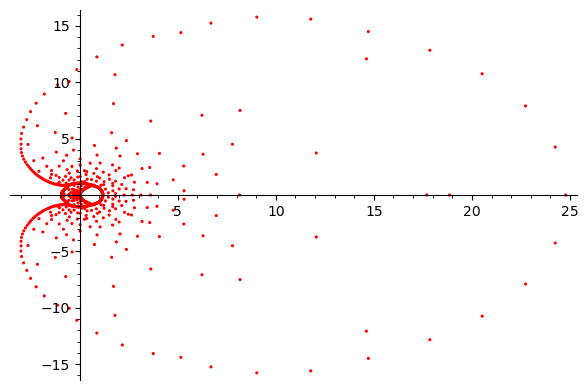

In [5]:
import pickle
rfile = open('/Users/barrybrent/3oct22no4.txt','rb') #superlong dagger Euler exponents polynomials
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)
ls=len(s)
for k in [ls-1..ls-1]:
    print("=====================================================================================")
    print("exponent: ",s[k][0])
    points=[]
    poly=s[k][1]
    poly=R(poly)
    pr=poly.roots(CC)
    lpr=len(pr)
    roots=[]
    for j in [0..lpr-1]:
        print("j: ",j)
        root=pr[j][0]
        imroot=imaginary(root)
        rlroot=real(root)
        rootpair=(rlroot,imroot)
        roots=roots+[rootpair]
       
    rootplot=list_plot(roots,color='red',size=5)
    show(rootplot)